# IE 423 Project Part 3

| Name |      ID      |
|----------|:-------------:|
| Yusuf Ali Bozkurt | 2019402021 |
| İbrahim Emre Köksal |  2019402   |
| İdil Zeynep Ceylan | 2020402 |
    

 Import the necessary libraries and load the image

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


image = cv2.imread('Desktop/0070.jpg', cv2.IMREAD_GRAYSCALE)

Plot the original image \
Plot the histogram with normal distribution fit

Estimated mean: 168.4600486755371
Estimated standard deviation: 16.007653979360114


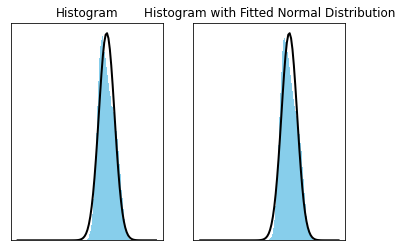

In [14]:
mean, std_dev = np.mean(image.ravel()), np.std(image.ravel())

print(f"Estimated mean: {mean}")
print(f"Estimated standard deviation: {std_dev}")
plt.subplot(1, 2, 1), plt.hist(image.ravel(), 256, [0, 256], density=True, color='skyblue')
plt.title('Histogram'), plt.xticks([]), plt.yticks([])
mean, std_dev = norm.fit(image.ravel())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)
plt.subplot(1, 2, 2), plt.hist(image.ravel(), 256, [0, 256], density=True, color='skyblue')
plt.title('Histogram with Fitted Normal Distribution'), plt.xticks([]), plt.yticks([])
plt.plot(x, p, 'k', linewidth=2)
plt.show()


Estimate mean and standard deviation for normal distribution \
Calculate lower and upper bounds for 0.001 probability limits \
0.999 to cover 99.9% of the distribution \
Identify pixels outside the bounds\
Set values of defective pixels to zero\
Count the number of defective pixels


In [4]:
mean, std_dev = np.mean(image.ravel()), np.std(image.ravel())
lower_bound = norm.ppf(0.001, loc=mean, scale=std_dev)
upper_bound = norm.ppf(0.999, loc=mean, scale=std_dev) 
defective_pixels = np.where((image < lower_bound) | (image > upper_bound))
defective_mask = np.zeros_like(image)
defective_mask[defective_pixels] = 1
num_defective_pixels = len(defective_pixels[0])

Plot the histogram

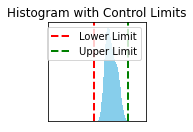

In [5]:
plt.subplot(2, 3, 4)
plt.hist(image.ravel(), 256, [0, 256], density=True, color='skyblue')
plt.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2, label='Lower Limit')
plt.axvline(x=upper_bound, color='g', linestyle='dashed', linewidth=2, label='Upper Limit')
plt.title('Histogram with Control Limits'), plt.xticks([]), plt.yticks([])
plt.legend()

Display the original and modified images

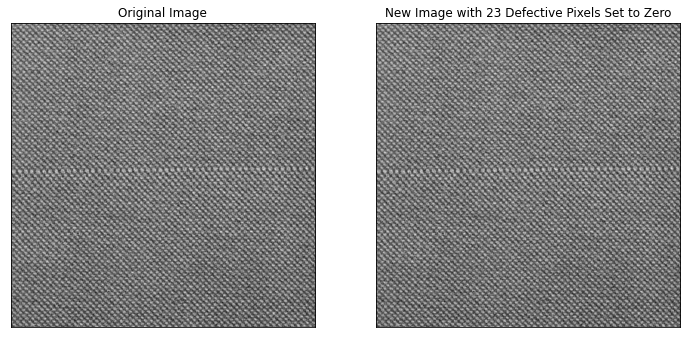

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread('0070.jpg', cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.title(f'New Image with {num_defective_pixels} Defective Pixels Set to Zero'), plt.xticks([]), plt.yticks([])
plt.show()

Print the number of defective pixels

In [8]:
print(f"Number of defective pixels: {num_defective_pixels}")

Number of defective pixels: 23


## Patch Method
Define window size \
Get image dimensions\
Step size for sliding window\
Function to apply defect detection and correction to each patch\
Estimate mean and standard deviation for normal distribution\
Calculate lower and upper bounds for 0.001 probability limits\
0.999 to cover 99.9% of the distribution\
Identify pixels outside the bounds\
Check if defective coordinates are not empty\
Print the coordinates of defective pixels\
Set values of defective pixels to zero in the original image\
Update the total defective count\
Iterate over patches using a sliding window\
Extract the patch\
Apply defect detection and correction to the patch\
Display the original and modified images\

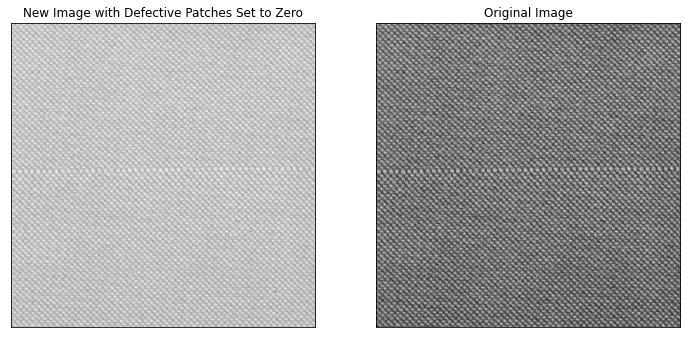

Total Defective Pixels: 766


In [11]:

window_size = (51, 51)
height, width = image.shape
step_size = 10
total_defective = 0

def apply_defect_correction(patch):
    global total_defective  
    mean, std_dev = np.mean(patch.ravel()), np.std(patch.ravel())

    lower_bound = norm.ppf(0.001, loc=mean, scale=std_dev)
    upper_bound = norm.ppf(0.999, loc=mean, scale=std_dev)   
    defective_pixels = np.where((patch < lower_bound) | (patch > upper_bound))


    if defective_pixels[0].size > 0:
        image[y + defective_pixels[0], x + defective_pixels[1]] = 0
        total_defective += len(defective_pixels[0])
for y in range(0, height - window_size[0] + 1, step_size):
    for x in range(0, width - window_size[1] + 1, step_size):
        patch = image[y:y + window_size[0], x:x + window_size[1]] 
        apply_defect_correction(patch)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('New Image with Defective Patches Set to Zero'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread('0070.jpg', cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.show()
print("Total Defective Pixels:", total_defective)

### Same Process for Rows only and Columns only\
Function to identify out-of-control pixels in a 1D array\
Function to process rows and columns\
Plot the original and modified images for rows\
Plot the original and modified images for columns\
Result is a bit higher in both cases, the reason is to see the difference between rows and columns more clearly, threshold is adjusted to 3-sigma in this case

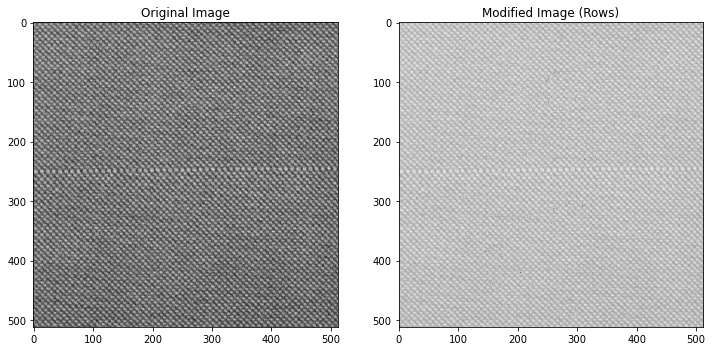

Number of pixels changed to zero in rows: 81


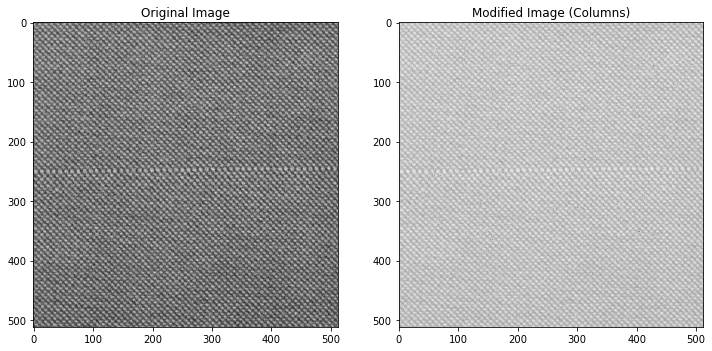

Number of pixels changed to zero in columns: 48


In [13]:
from PIL import Image
image_path = '0070.jpg'
original_image = np.array(Image.open(image_path).convert('L'))
def find_out_of_control_pixels(data, threshold=3):
    mean_val = np.mean(data)
    std_dev = np.std(data)
    out_of_control = np.abs(data - mean_val) > threshold * std_dev
    return out_of_control

def process_rows_and_columns(image, axis_name):
    modified_image = image.copy()
    num_changed_pixels = 0
    
    for i in range(image.shape[0]):
        data = image[i, :] if axis_name == 'row' else image[:, i]
        out_of_control_pixels = find_out_of_control_pixels(data)
        if axis_name == 'row':
            modified_image[i, out_of_control_pixels] = 0
        else:
            modified_image[out_of_control_pixels, i] = 0
        num_changed_pixels += np.sum(out_of_control_pixels)
    
    return modified_image, num_changed_pixels
modified_image_rows, num_changed_pixels_rows = process_rows_and_columns(original_image, 'row')
modified_image_columns, num_changed_pixels_columns = process_rows_and_columns(original_image, 'column')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(original_image, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(modified_image_rows, cmap='gray')
axs[1].set_title('Modified Image (Rows)')
plt.show()
print(f"Number of pixels changed to zero in rows: {num_changed_pixels_rows}")
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(modified_image_columns, cmap='gray')
axs[1].set_title('Modified Image (Columns)')
plt.show()
print(f"Number of pixels changed to zero in columns: {num_changed_pixels_columns}")


### Our Proposal
Flatten the image to create a 2D array of pixel values\
Calculate the mean vector and covariance matrix for all pixels\
Add a small regularization term to the covariance matrix\
Calculate the inverse covariance matrix\
Calculate Mahalanobis distances\
Calculate the threshold based on the chi-squared distribution\
Identify and replace defective pixels with zero\
Reshape the modified flat image back to its original shape



In [ ]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
from PIL import Image

image_path = '/Users/ibrahimemrekoksal/Desktop/0070.jpg' #Also run for other 5 random examples
original_image = np.array(Image.open(image_path))
modified_image = original_image.copy()
flat_image = original_image.reshape(-1, original_image.shape[2])


mean_vector = np.mean(flat_image, axis=0)
covariance_matrix = np.cov(flat_image, rowvar=False)

ridge = 1e-5
covariance_matrix += ridge * np.identity(covariance_matrix.shape[0])

inv_covariance_matrix = np.linalg.inv(covariance_matrix)
delta = flat_image - mean_vector
mahalanobis_dist_squared = np.sum(delta @ inv_covariance_matrix * delta, axis=1)
threshold = chi2.ppf(0.999, flat_image.shape[1]) 
defected_pixels = mahalanobis_dist_squared > threshold
modified_image.reshape(-1, modified_image.shape[2])[defected_pixels, :] = 0
modified_image = modified_image.reshape(original_image.shape)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(modified_image)
axs[1].set_title('Modified Image with Defected Pixels Set to Zero')

plt.show()

num_defective_pixels = np.sum(defected_pixels)
print(f"Number of defective pixels: {num_defective_pixels}")
